## Data Description

In [ ]:
!pip install -U pandasql

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
df = pd.read_excel('datasample.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2019-12-01 08:26:00,3.39,17850.0,United Kingdom
1,536367.0,84879.0,ASSORTED COLOUR BIRD ORNAMENT,32.0,2019-12-01 08:34:00,1.69,13047.0,United Kingdom
2,536367.0,21755.0,LOVE BUILDING BLOCK WORD,3.0,2019-12-01 08:34:00,5.95,13047.0,United Kingdom
3,536368.0,22914.0,BLUE COAT RACK PARIS FASHION,3.0,2019-12-01 08:34:00,4.95,13047.0,United Kingdom
4,536373.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2019-12-01 09:02:00,2.75,17850.0,United Kingdom


In [ ]:
print(df.shape)
print(df.dtypes)

df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

(54214, 8)
InvoiceNo              object
StockCode              object
Description            object
Quantity              float64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object
['Quantity' 'UnitPrice' 'CustomerID']
['InvoiceNo' 'StockCode' 'Description' 'InvoiceDate' 'Country']


<AxesSubplot:>

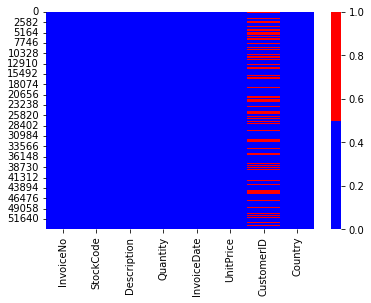

In [ ]:
cols = df.columns[:8]
colours = ['Blue', 'Red'] # Красный пропущенные данные
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

The above represents all the data from the dataset, and missing values are highlighted in red. These values belong to the CustomerID column, and in the future, I will be excluding such data since there are not many of them, and their absence has a negligible impact on the metrics. It is also worth noting that missing values are present in the Description column, but for some reason, the above graph does not mark them.

<AxesSubplot:>

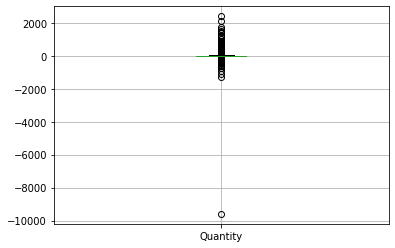

In [ ]:
df.boxplot(column=['Quantity'])

In [ ]:
df['Quantity'].describe()

count    54214.000000
mean         9.610802
std         57.358422
min      -9600.000000
25%          1.000000
50%          3.000000
75%         10.000000
max       2400.000000
Name: Quantity, dtype: float64

As evident from the box plot, there is a significant outlier at the -9600 mark.

In [ ]:
df.loc[df['Quantity'] < -2000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
22627,556691.0,23005.0,printing smudges/thrown away,-9600.0,2020-06-14 10:37:00,0.0,NaN,United Kingdom


In [ ]:
dfk = df.loc[df['Quantity'] > -2000]

<AxesSubplot:>

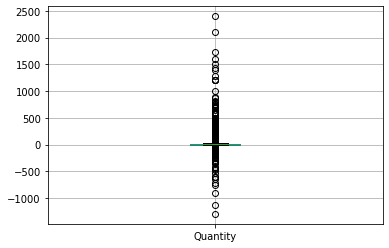

In [ ]:
dfk.boxplot(column=['Quantity'])

A normal row contains the description: "printing smudges/thrown away." The question about the meaning of this row (Possibly defective) needs clarification from the supplier. I will exclude this row as it may introduce noise into the metrics and significantly impact the mean.

In [ ]:
dfh = ps.sqldf("""
      select Description, CustomerID, count(Description) as Count
      from df 
      where upper(Description) != Description
      group by Description, CustomerID
      order by Description desc
      """)
dfh.head()

,Description,CustomerID,Count
0,wrongly sold as sets,NaN,1
1,wrongly marked 23343,NaN,1
2,wrong code?,NaN,1
3,wrong barcode (22467),NaN,1
4,wet/rusty,NaN,1


As a trend, I noticed that Description in lowercase does not have a CustomerID. These values collectively can be discarded.

In [ ]:
dfl = ps.sqldf("""
      select StockCode, Description, count(StockCode) as StockAmount
      from df 
      group by StockCode
      order by StockAmount desc
      """)
dfl.head()

,StockCode,Description,StockAmount
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,237
1,85099B,JUMBO BAG RED RETROSPOT,222
2,22423.0,REGENCY CAKESTAND 3 TIER,204
3,20725.0,LUNCH BAG RED RETROSPOT,175
4,21212.0,PACK OF 72 RETROSPOT CAKE CASES,164


StockCode - The unique product code, through which I reflected the StockAmount (the quantity of each product or service).

In [ ]:
dft = ps.sqldf("""
      select InvoiceNo, Description, sum(Total) as Total, Country
      from
        (
          select InvoiceNo, Description, Country,
          (Quantity * UnitPrice) as Total, Country
          from df
          group by Description, Total
        )
      where Total > 0
      group by Description, Country
      order by Total desc
      """)
dft.head()

,InvoiceNo,Description,Total,Country
0,560755.0,DOTCOM POSTAGE,20607.25,United Kingdom
1,536607.0,REGENCY CAKESTAND 3 TIER,5903.78,United Kingdom
2,537955.0,HEART OF WICKER LARGE,4484.28,United Kingdom
3,542727.0,METAL SIGN TAKE IT OR LEAVE IT,4055.88,United Kingdom
4,553035.0,REGENCY TEAPOT ROSES,3691.83,United Kingdom


The metric above is the total profit from each product (quantity multiplied by the cost per unit). As we can observe, DOTCOM POSTAGE predominates in the market, representing expenses for shipping orders.

In [ ]:
dfy = ps.sqldf("""
      select InvoiceNo, Description, sum(Total) as Total, Country
      from
        (
          select InvoiceNo, Description, Country,
          (Quantity * UnitPrice) as Total 
          from df
          group by Description, Total, Country
        )
      where Total < 0
      group by Description, Country
      order by Total asc
      """)
dfy.head()

,InvoiceNo,Description,Total,Country
0,C551699,Manual,-10505.58,United Kingdom
1,C564341,AMAZON FEE,-8847.55,United Kingdom
2,C567527,PANTRY CHOPPING BOARD,-3825.36,United Kingdom
3,C546557,Manual,-2583.76,Hong Kong
4,C565044,IVORY DINER WALL CLOCK,-2441.20,United Kingdom


If we consider negative values of the product quantity as returns, then the metric above indicates all returns. Items such as AMAZON FEE are excluded, representing the sum of Amazon's profit. Negative values typically begin with the letter C, and I assume it's a special label for negative Total values, but this is just my hypothesis.

In [ ]:
df.loc[df['Description'] == "AMAZON FEE"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,id
31245,C564341,AMAZONFEE,AMAZON FEE,-1.0,2020-08-24 14:53:00,6662.51,NaN,United Kingdom,31246
42864,C573550,AMAZONFEE,AMAZON FEE,-1.0,2020-10-31 13:32:00,2185.04,NaN,United Kingdom,42865


In [ ]:
dfm = ps.sqldf("""
      with cte as (
      select distinct Country, CustomerID
      from df
      )
      select Country, count(CustomerID) as Amount
      from cte
      group by Country
      order by Amount desc
      """)
dfm.head(5)

,Country,Amount
0,United Kingdom,3441
1,Germany,87
2,France,79
3,Spain,26
4,Belgium,24


Unique users by country.

In [ ]:
dfu = ps.sqldf("""
      select Country, count(CustomerID) as Amount
      from df 
      group by Country
      order by Amount desc
      limit 10
      """)
dfu.head(5)

,Country,Amount
0,United Kingdom,36170
1,Germany,951
2,France,874
3,EIRE,720
4,Spain,253


In [ ]:
dfn = ps.sqldf("""
      select Country, count(CustomerID) as Amount
      from df 
      group by Country
      order by Amount desc
      """)
dfn.head(5)

,Country,Amount
0,United Kingdom,36170
1,Germany,951
2,France,874
3,EIRE,720
4,Spain,253


## Insights and data visualization

In [ ]:
fig = px.pie(dfu, values = "Amount", names = "Country", title = "Orders Per Country")
fig.show()

In [ ]:
fig = px.choropleth(dfn, locationmode = 'country names', locations = "Country", \
                     color = "Amount", hover_name = "Country",\
                     color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

From the above diagrams, we can see that the majority of service users are in the United Kingdom.

In [ ]:
dfi = ps.sqldf("""
      select Date, Accum as Amount
      from
        (
          select strftime('%m/%Y', Date) as Date, Accum
          from
            (
              select InvoiceDate as Date, 
              sum(amount) over (order by InvoiceDate) as Accum
              from
                (
                  select (Quantity * UnitPrice) as Amount, InvoiceDate
                  from df
                )
            group by InvoiceDate
            )
        )
        group by Date
        order by Accum
      """)
dfi.head(2)

,Date,Amount
0,12/2019,20.34
1,01/2020,24952.26


In [ ]:
hist1 = px.area(dfi, x = "Date", y = "Amount", title = "Revenue growth", markers=True)
hist1.show()

The above graph represents the growth of revenue within the platform from December 2019 to December 2020, based on total orders, reaching the mark of 350,000. This indicates that the cost of all products and services within the service exceeded the 300,000 mark over the 12 months.

In [ ]:
dfp = ps.sqldf("""
      select substr(Date, 6, 1) as Ord, Date, Amount / Id_c as ARPU
      from
        (
          select count(CustomerID) as Id_c, Date, sum(Amount) as Amount
          from
            (
              select strftime('%m/%Y', InvoiceDate) as Date, 
              (Quantity * UnitPrice) as Amount,
              CustomerID
              from df
              where not CustomerID is Null
              group by CustomerID
            )
          group by Date
        )
      order by Ord
      """)
dfp

,Ord,Date,ARPU
0,1,12/2019,24.447972
1,2,01/2020,29.773664
2,2,02/2020,20.983841
3,2,03/2020,20.930078
4,2,04/2020,24.391950
5,2,05/2020,23.285792
6,2,06/2020,26.994267
7,2,07/2020,20.864247
8,2,08/2020,23.800645
9,2,09/2020,22.914843


In [ ]:
hist2 = px.histogram(dfp, x = "Date", y = "ARPU", title = "Average Revenue Per User")
hist2.show()

The above graph shows ARPU (average revenue per user), the average income per user. As seen, the peak revenue per user occurred in December 2020 and amounted to 105.957442. This value appears to be incorrect since there were only 43 unique users in December. A small number of users inflates the ARPU value for a large sum, leading to such a peak.

In [ ]:
#@title
dfh = ps.sqldf("""
      select CustomerID, FirstDay, LastDay,
      case when FirstDay = LastDay then 1 end as Left,
      case when FirstDay != LastDay then 1 end as Stayed
      from
        (
          select CustomerID, min(Date) as FirstDay, max(Date) as LastDay
          from
            (
              select strftime('%m/%Y', InvoiceDate) as Date, 
              CustomerID
              from df
            )
          where not CustomerID is Null
          group by CustomerID
        )
      """)
dfh

In [ ]:
dfj = ps.sqldf("""
      select substr(FirstDay, 6, 1) as Ord, FirstDay as Date, 
      LeftPerMonth*1.0 as LPM, 
      coalesce(StayedPerMonth, 0)*1.0 as SPM,
      (LeftPerMonth*1.0) + coalesce(StayedPerMonth, 0)*1.0 as MAU,
      100 - round((coalesce(StayedPerMonth, 0)*1.0 / ((LeftPerMonth*1.0) 
      + coalesce(StayedPerMonth, 0)*1.0)), 3) * 100
      as CRR
      from
        (
          select FirstDay, sum(Left) as LeftPerMonth, 
          sum(Stayed) as StayedPerMonth
          from
            (
              select FirstDay,
              case when FirstDay = LastDay then 1 end as Left,
              case when FirstDay != LastDay then 1 end as Stayed
              from
                (
                  select CustomerID, min(Date) as FirstDay, 
                  max(Date) as LastDay
                  from
                    (
                      select strftime('%m/%Y', InvoiceDate) as Date, 
                      CustomerID
                      from df
                    )
                  where not CustomerID is Null
                  group by CustomerID
                )
            )
          group by FirstDay
        )
      order by Ord
      """)
dfj

,Ord,Date,LPM,SPM,MAU,CRR
0,1,12/2019,110.0,5.0,115.0,95.7
1,2,01/2020,81.0,508.0,589.0,13.8
2,2,02/2020,88.0,324.0,412.0,21.4
3,2,03/2020,124.0,330.0,454.0,27.3
4,2,04/2020,111.0,219.0,330.0,33.6
5,2,05/2020,84.0,198.0,282.0,29.8
6,2,06/2020,88.0,153.0,241.0,36.5
7,2,07/2020,87.0,118.0,205.0,42.4
8,2,08/2020,85.0,78.0,163.0,52.1
9,2,09/2020,172.0,136.0,308.0,55.8


In [ ]:
hist4 = px.histogram(dfj, x = "Date", y = "MAU", title = "Monthly Active Users")
hist4.show()

In [ ]:
hist3 = px.histogram(dfj, x="Date", y="CRR", title = "Customer Retention Rate")
hist3.show()

LPM (Left Per Month) - The number of unique users who left the service without making a repeat purchase. SPM (Stayed Per Month) - The number of unique users who preferred to make a repeat purchase after some time. MAU (Monthly Active Users) - The number of active users per month. The desired metric, CRR (Customer Retention Rate), indicates the customer churn rate, showing the percentage of customers, out of the total, who decided to leave the service for an entire month and, consequently, not make a repeat purchase. The histograms above indicate a high level of customer churn from the service. In December 2020, the churn is highest due to the dataset's discontinuity with a minimal number of values for December.

In [ ]:
dfg = ps.sqldf("""
      with cte1 as
        (
          with cte as
            (
              select CustomerID, min(Date) as FirstDay, 
              max(Date) as LastDay
              from
                (
                  select strftime('%m/%Y', InvoiceDate) as Date, 
                  CustomerID
                  from df
                )
              where not CustomerID is Null
              group by CustomerID
            )
          select count(CustomerID) as WholeAmount,
          (select count(CustomerID) from cte where FirstDay != LastDay) 
          as Stayed,
          (select count(CustomerID) from cte where FirstDay = LastDay) 
          as Left
          from cte
        )
      select WholeAmount, Stayed, Left, 
      round((Stayed* 1.0/WholeAmount) * 100, 2)  as RCR
      from cte1
      """)
dfg

,WholeAmount,Stayed,Left,RCR
0,3819,2229,1590,58.37


There are a total of 3819 unique customers, out of which 2229 made a repeat purchase, and 1590 customers made a purchase only once and did not return to the service during the reporting period. Therefore, the Return Customer Rate (percentage of customers making a repeat purchase) is 58.37%.

In [ ]:
dfa = ps.sqldf("""
      select InvoiceAmount, CustomerUnique, OrderSum, 
      OrderSum / CountID as IncomePerCus, 
      OrderSum / InvoiceAmount as IncomePerInv
      from
      (
        select (select count(InvoiceNo)
        from
          (
            select distinct InvoiceNo
            from df
            where not CustomerID is Null
          )) as InvoiceAmount, (select count(CustomerID)
        from
          (
            select distinct CustomerID
            from df
            where not CustomerID is Null
          )) as CustomerUnique,
        sum(Quantity * UnitPrice) as OrderSum,
        (
          select count(CustomerID)
          from df
          where not CustomerID is Null
        ) as CountID
        from df
        where not CustomerID is Null
        group by InvoiceAmount, CustomerUnique
      )
      """)
dfa.head()

,InvoiceAmount,CustomerUnique,OrderSum,IncomePerCus,IncomePerInv
0,13673,3819,840206.211,20.672839,61.450026


The total number of invoices is 13,673, with 3,819 unique users throughout the report. The total amount of all orders is 840,206.211. The average order value is 20.672839, and the average order value per invoice is 61.450026.

## Conclusion

In conclusion, the service is experiencing significant customer churn. To address this situation, it is necessary to delve deeper, obtain additional data that will allow us to answer the question: Why? Only the customer can help us uncover all the nuances and understand the situation better. We cannot seek salvation through third-party services providing data, as all information related to orders, delivery, recipients, and other confidential data belongs to the customer.